Non linear Method

## Communications:

In [1]:
data <- read.csv(file.path("..", "data", "training_data.csv"))

In [15]:
set.seed(199)
idx.train <- sample(nrow(data), nrow(data)*2/3)
data.train <- data[idx.train,]
data.test <- data[-idx.train,]
#using more data samples
datax.train<-data.train[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))]
datay.train<-data.train$VALENCE.PLEASANTNESS

datax.test<-data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))]
datay.test<-data.test$VALENCE.PLEASANTNESS


In [17]:
#first approach with neuralnetworks

library(keras)
use_condaenv("r-tensorflow")

nn <- keras_model_sequential() %>%
      layer_dense(units = 4, activation = 'relu', input_shape = c(2)) %>%
      layer_dense(units = 1, activation = 'sigmoid') # append layers
summary(nn)

history <- nn %>% fit(
    as.matrix(datax.train),
    datay.train,
    batch_size = ncols(datax.train),
    epochs = 1000,
    validation_split = 0, # use all data for training, none for validation.
)
plot(history)

pred <- predict(nn, as.matrix(datax.train))
plot(datax.train, col = pred+2)
misclassified <- pred != datay.train
points(X[misclassified,], pch = 4)

ERROR: Error: Python module tensorflow.python.keras was not found.

Detected Python configuration:

python:         C:\PROGRA~3\ANACON~1\python.exe
libpython:      C:/PROGRA~3/ANACON~1/python38.dll
pythonhome:     C:\PROGRA~3\ANACON~1
version:        3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
Architecture:   64bit
numpy:          C:\PROGRA~3\ANACON~1\lib\site-packages\numpy
numpy_version:  1.18.5
tensorflow:     [NOT FOUND]

python versions found: 
 C:\ProgramData\Anaconda3\envs\r-tensorflow\python.exe
 C:\PROGRA~3\ANACON~1\envs\MLPROJ~1\python.exe
 C:\PROGRA~3\ANACON~1\python.exe
 C:\ProgramData\Anaconda3\python.exe
 C:\ProgramData\Anaconda3\envs\MLproject\python.exe
 C:\ProgramData\Anaconda3\envs\bio322\python.exe




In [ ]:
#with convolutional layers
conv.nn <- keras_model_sequential()
conv.nn %>%
  layer_conv_2d(32, c(5, 5), activation = 'relu', input_shape = c(32, 32, 1)) %>%
  layer_conv_2d(64, c(5, 5), activation = 'relu') %>%
  layer_flatten() %>%
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dense(units = 1, activation = 'sigmoid')
conv.nn %>% compile(
  loss = 'binary_crossentropy',
  optimizer = 'adam',
  metrics = c('accuracy')
)
history <- conv.nn %>% fit(
  x_train, y_train,
  epochs = 5, batch_size = 128,
  validation_split = 0.1
)
plot(history)

## Trees

peut etre faire cross validation sur la methode qui donne le moins de RMSE 

In [11]:
#attention : changer data pour que sweet or sour ne soit pas dedans 
data <- read.csv(file.path("..", "data", "training_data.csv"))

In [12]:
library(tree)
library(randomForest)
library(xgboost)

In [13]:
set.seed(199)
idx.train <- sample(nrow(data), nrow(data)/2)
data.train <- data[idx.train,]
data.test <- data[-idx.train,]

data.train.x <- data.train[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))]
#data.train.x <- as.matrix((model.matrix(~.-1, data.train.x)))
data.train.y <- data.train$VALENCE.PLEASANTNESS

data.test.x <- data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))]
#data.test.x<- as.matrix((model.matrix(~.-1, data.test.x)))
data.test.y <- data.test$VALENCE.PLEASANTNESS

In [8]:
#Tree ok
tree.data.train <- tree(VALENCE.PLEASANTNESS ~ ., data = data.train)
summary(tree.data.train)
#plot(tree.data)
#text(tree.data, pretty = 0,cex=0.4)

pred.test <- predict(tree.data.train, newdata = data.test.x)
MSE.test <- mean((pred.test - data.test.y)^2)
RMSE.test <- sqrt(MSE.test)
print(paste0('test MSE :', MSE.test))
print(paste0('test RMSE :', RMSE.test))

pred.train <- predict(tree.data.train,data.train.x)
MSE.train <- mean((pred.train - data.train.y)^2)
RMSE.train <- sqrt(MSE.train)
print(paste0('train MSE :', MSE.train))
print(paste0('train RMSE :', RMSE.train))



Regression tree:
tree(formula = VALENCE.PLEASANTNESS ~ ., data = data.train)
Variables actually used in tree construction:
 [1] "SWEETORSOUR" "R3e."        "Mor10s"      "E1m"         "Mor22p"     
 [6] "RDF040e"     "R6s"         "Mor06m"      "LOC"         "G3u"        
[11] "Mor24v"      "Mor09s"      "HATS6p"      "R6s."       
Number of terminal nodes:  15 
Residual mean deviance:  157.2 = 53310 / 339 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-39.670  -7.163  -1.392   0.000   6.988  32.350 

[1] "test MSE :431.818095518114"
[1] "test RMSE :20.7802332883467"
[1] "train MSE :150.580045341501"
[1] "train RMSE :12.2711061172782"


In [10]:
#Pruning tree ne fonctionne pas !
#pruning_tree <- function(b,data.train,data.test) {
#    tree.train <- tree(VALENCE.PLEASANTNESS ~ ., data = data.train)
#    pt <- prune.tree(tree.train, best = b) #ntree = 500 by default
#    pred <- predict(pt, data.test)
#    MSE = mean((pred - data.test$VALENCE.PLEASANTNESS)^2)
#    sqrt(MSE)
#}

#RMSE <- sapply(1:50, pruning_tree, data.train, data.test)

#plot(50:100,RMSE,xlab='m',ylab='RMSE')
#which.min(RMSE) # min = 100
#print(paste0('m that give the min test RMSE is :', which.min(RMSE))) 
#print(paste0('test RMSE min :', RMSE(which.min(RMSE))))

In [ ]:
#Random Forest 
random_forest <- function(m,data.train,data.test) {
    rf <- randomForest(VALENCE.PLEASANTNESS ~ ., data = data.train, mtry = m) #ntree = 500 by default
    pred <- predict(rf, data.test[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))])
    MSE = mean((pred - data.test$VALENCE.PLEASANTNESS)^2)
    sqrt(MSE)
}

RMSE.test <- sapply(50:100, random_forest, data.train, data.test)
#I choose m between 50 and 100 because sqrt(p) = 70 = typical choice for random forest
plot(50:100,RMSE.test,xlab='m',ylab='test RMSE')
which.min(RMSE.test) # min = 100
print(paste0('m that give the min test RMSE is :', which.min(RMSE.test) + 49)) #Change the 49 if we change the intervall of m 50:100
print(paste0('test RMSE min :', RMSE.test(which.min(RMSE.test))))

#--> m that give the min RMSE is 100
#--> min RMSE little less than 22

rf <- randomForest(VALENCE.PLEASANTNESS ~ ., data = data.train, mtry = 100)
pred.train <- predict(rf, data.train.x)
RMSE.train <- sqrt(mean((pred.train-data.train.y)^2))
print(paste0('train RMSE min :', RMSE.train)

In [14]:
#Bagging ok
set.seed(1)
m <- 4871 # in Bagging, we consider all the predictors as split candidates
bag <- randomForest(VALENCE.PLEASANTNESS ~ ., data = data.train, mtry = m) #ntree = 500 par defaut, peut etre essayer avec 1000 une fois ?
pred.bag.test <- predict(bag, newdata = data.test.x)
MSE.test = mean((pred.bag.test - data.test.y)^2)
RMSE.test = sqrt(MSE.test)
print(paste0('test MSE :', MSE.test))
print(paste0('test RMSE :', RMSE.test))
#--> RMSE = 18.4237592975258

pred.bag.train <- predict(bag,data.train.x)
MSE.train = mean((pred.bag.train - data.train.y)^2)
RMSE.train = sqrt(MSE.train)
print(paste0('train MSE :', MSE.train))
print(paste0('train RMSE :', RMSE.train))

[1] "test MSE :339.434906653168"
[1] "test RMSE :18.4237592975258"
[1] "train MSE :53.342499383093"
[1] "train RMSE :7.3035949629681"


In [15]:
#Boosting with cross sur le meilleur lambda?

data.test.x<- as.matrix((model.matrix(~.-1, data.test.x)))
data.train.x <- as.matrix((model.matrix(~.-1, data.train.x)))

set.seed(1)
pows <- seq(-3.5, -0.2, by = 0.1)
lambdas <- 10^pows
train.err <- rep(NA, length(lambdas))
test.err <- rep(NA, length(lambdas))
for (i in 1:length(lambdas)) {
  boost <- xgboost(data.train.x,
                           label=data.train.y,
                           eta=lambdas[i],
                           objective="reg:squarederror",
                           max.depth=3,
                           nrounds=1000,
                           verbose = 0)
  pred.train <- predict(boost, data.train.x)
  pred.test <- predict(boost, data.test.x)
  train.err[i] <- mean((pred.train - data.train.y)^2)
  test.err[i] <- mean((pred.test - data.test.y)^2)
}

MSEmin.test <- min(test.err)
lambdamin.test <- lambdas[which.min(test.err)]
MSEmin.train <- min(train.err)
lambdamin.train <- lambdas[which.min(train.err)]

print(paste0('test RMSE :', sqrt(MSEmin.test)))
print(paste0('lambda min test :', lambdamin.test))
print(paste0('train RMSE :', sqrt(MSEmin.train)))
print(paste0('lambda min test :', lambdamin.train))

[1] "test RMSE :18.0767386190859"
[1] "lambda min test :0.00398107170553497"
[1] "train RMSE :1.54590890264531"
[1] "lambda min test :0.630957344480193"


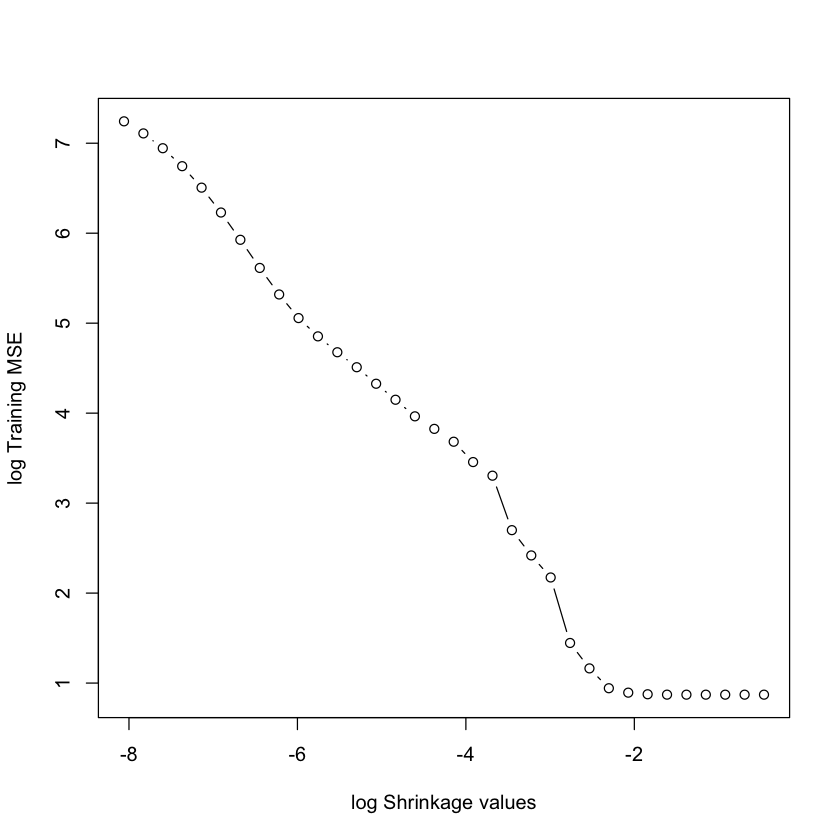

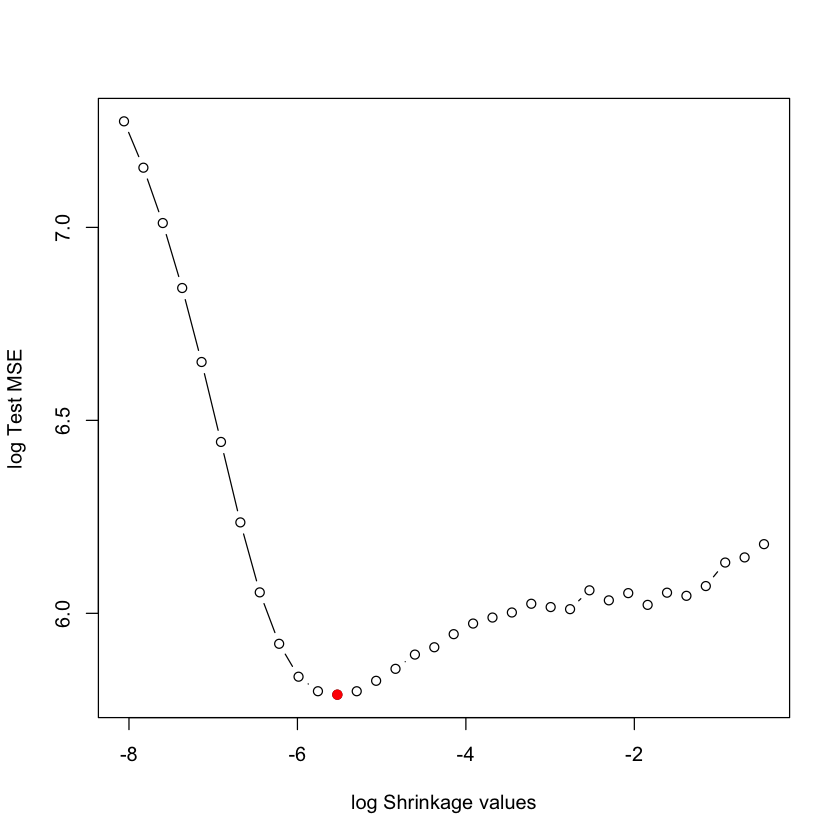

In [16]:
plot(log(lambdas), log(train.err), type="b", xlab="log Shrinkage values", ylab="log Training MSE")
plot(log(lambdas), log(test.err), type="b", xlab="log Shrinkage values", ylab="log Test MSE")
points(log(lambdas[which.min(test.err)]), log(min(test.err)), col="red", pch=19)

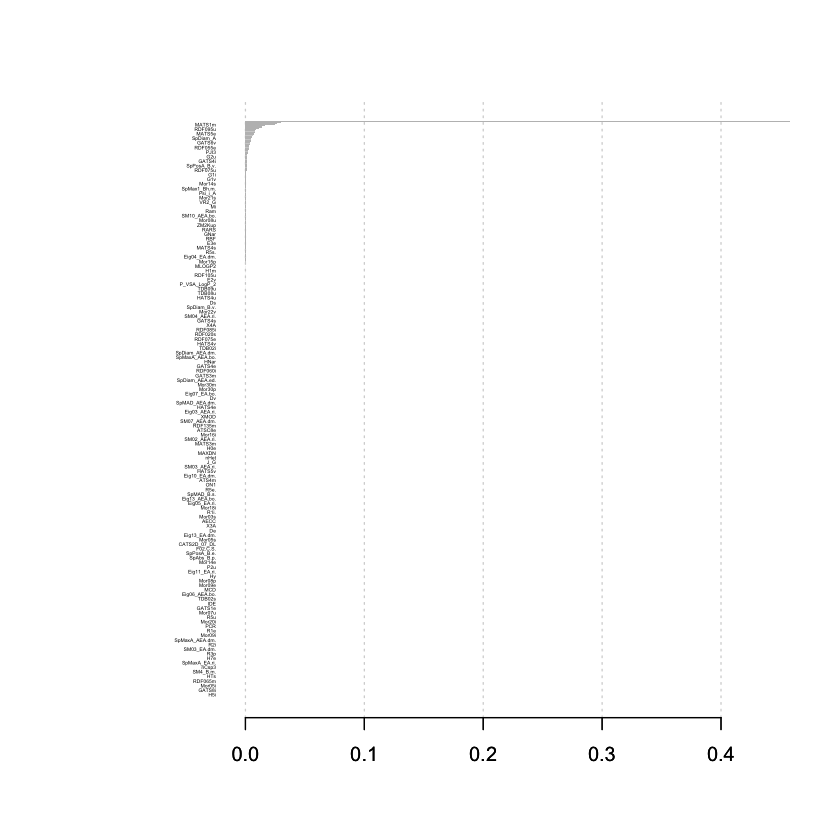

In [17]:
importance_matrix <- xgb.importance(model=boost)
xgb.plot.importance(importance_matrix=importance_matrix)

In [13]:
#Pruning tree with cv ok
#We run 6-fold cross-validation, because our training data has size 354, which is a multiple of 6.

function.train <- function(train) {
    formula <- data$VALENCE.PLEASANTNESS ~ .
    tree(formula, data, subset = train)
}
evaluate <- function(tree, set) {
    sapply(2:10, function(i) mean((data$VALENCE.PLEASANTNESS[set] - predict(prune.tree(tree, best = i), data[set,]))^2)) # We compute the mean squared error for all trees with 2 to 10 leaf nodes.
}
           
           #log(Hitters[set,'Salary'])
data.cv <- function(train) {
    res <- sapply(1:6, function(v) {
                            idx.test <- seq((v-1)*22 + 1, v*22) # fold index
                            this.fold.test <- train[idx.test]   # validation
                            this.fold.train <- train[-idx.test] # training
                            tree <- function.train(this.fold.train)
                            evaluate(tree, this.fold.test)
                        })
    rowMeans(data.frame(res))
}
           
train.and.evaluate <- function() {
    train <- sample(nrow(data), 354) #nrow = 708 et 354 = training set
    tree <- function.train(train)
    list(train = evaluate(tree, train),
         test = evaluate(tree, -train),
         cv = data.cv(train),
         tree = tree)
}
           
set.seed(1)
           
res <- replicate(100, train.and.evaluate()) # we run everything for 100 different training sets

In [ ]:
#a voir si ca compile
for(i in 1:3) {
    df <- data.frame(res[i,])
    m <- rowMeans(df)
    RMSE <- sqrt(rowMeans((df - m)^2))
    print(paste0('RMSE ',i,' : ', RMSE))
}
#1=train RMSE
#2=test RMSE
#3=CV

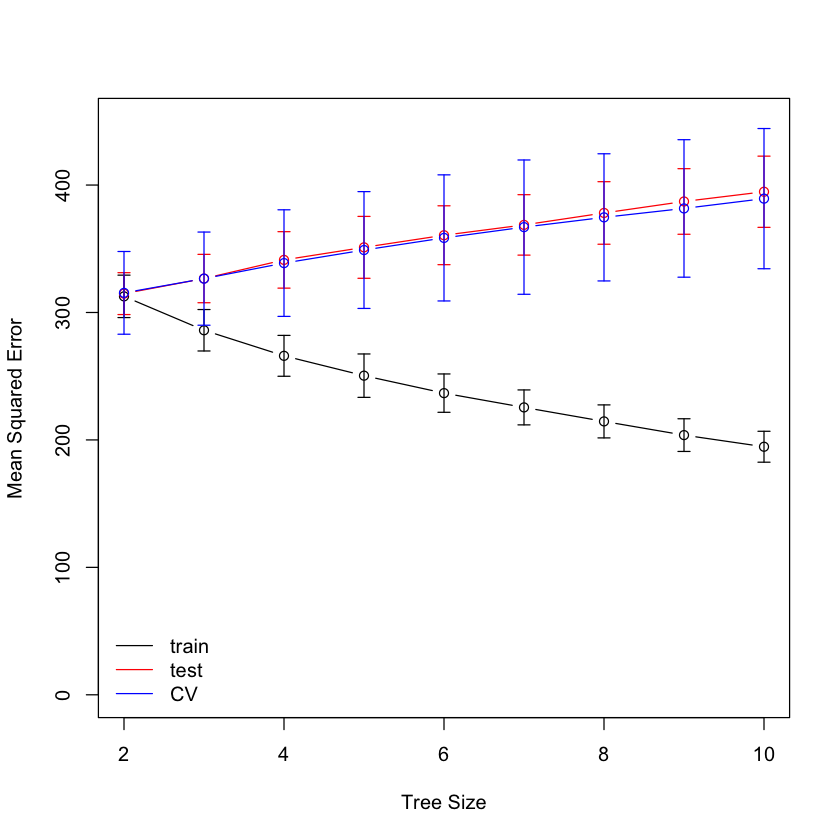

In [17]:
std.plot <- function(data, x = 2:10, ...) {
    df <- data.frame(data)
    m <- rowMeans(df)
    std <- sqrt(rowMeans((df - m)^2))
    points(x, m, type = "b", ...)
    arrows(x, m - std, x, m + std, length=0.05, angle=90, code=3, ...)
}
#attention ici j'ai l'inpressioin que c'est une RMSE au lieu d'une MSE ? a cause du sqrt dans stdplot
#print(paste0('the min train MSE :', res[1,which.min(res[1,])]))
#print(paste0(res[2,which.min(res[1,])]))
#print(paste0(res[3,which.min(res[1,])]))

plot(c(), ylim = c(.1, 450), xlim = c(2, 10), xlab = "Tree Size", ylab = "Mean Squared Error")
std.plot(res[1,])
std.plot(res[2,], col = "red")
std.plot(res[3,], col = "blue")
legend("bottomleft", c("train", "test", "CV"), bty = 'n', col = c("black", "red", "blue"), lty = 1)
#final.tree <- prune.tree(hitters.train(1:nrow(Hitters)), best = ????)
#plot(final.tree)
#text(final.tree)